# PHYS-467 Machine Learning for Physisicst
### Assignment 3: Predicting Atomization Energies with Neural Nets


#### Guilherme Simplício

In [1]:
#All important imports for the whole code

import numpy as np 
import torch 
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
np.random.seed(10)

# Exercise 1
The dataset is stored as a dictionary in the file dataset.pt and is already divided into train,
validation, and test sets, with keys X train, y train, X val, y val, and X test, y test respectively.
The tensors X’s contain the upper triangular parts of the normalized Coulomb matrices, and the
tensors y’s the atomization energies of the molecules in units of kcal/mol. Open the dataset using
torch.load.

In [3]:
dataset = torch.load("dataset.pt")

In [4]:
#to check if the data has been correctly stored, one can simply run this cell:
dataset

{'X_train': tensor([[ 5.1027,  1.4530,  5.1027,  ..., -0.3168, -0.3168, -0.3168],
         [ 7.1501,  1.7468,  5.1027,  ..., -0.3168, -0.3168, -0.3168],
         [ 7.1501,  3.7440,  3.4268,  ..., -0.3168, -0.3168, -0.3168],
         ...,
         [ 7.1501,  1.2805,  7.1501,  ..., -0.3168, -0.3168, -0.3168],
         [ 7.1501,  3.1458,  3.4268,  ..., -0.3168, -0.3168, -0.3168],
         [ 7.1501,  1.3803,  5.1027,  ..., -0.3168, -0.3168, -0.3168]]),
 'y_train': tensor([-1655.6700, -1332.6200, -1717.9399,  ..., -1239.8700, -1713.2700,
         -1447.5900]),
 'X_val': tensor([[ 7.1501,  1.3131,  5.1027,  ..., -0.3168, -0.3168, -0.3168],
         [ 7.1501,  2.1739,  5.1027,  ..., -0.3168, -0.3168, -0.3168],
         [ 7.1501,  1.1284,  7.1501,  ..., -0.3168, -0.3168, -0.3168],
         ...,
         [ 7.1501,  1.5263,  7.1501,  ..., -0.3168, -0.3168, -0.3168],
         [ 5.1027,  2.6138,  3.4268,  ..., -0.3168, -0.3168, -0.3168],
         [ 7.1501,  1.5531,  5.1027,  ..., -0.3168, -0.3168,

# Exercise 2
To inspect the labels y’s, make a histogram of the atomization energies of the molecules contained
in the training set. Then normalize the train, validation, and test labels by subtracting the mean and
dividing by the standard deviation of the train labels. This procedure helps to speed up the convergence
of the optimization dynamics and to avoid numerical instabilities. Keep track of the mean and the
standard deviation that you used to normalize in order to be able to unnormalize the energies once
the training is done.

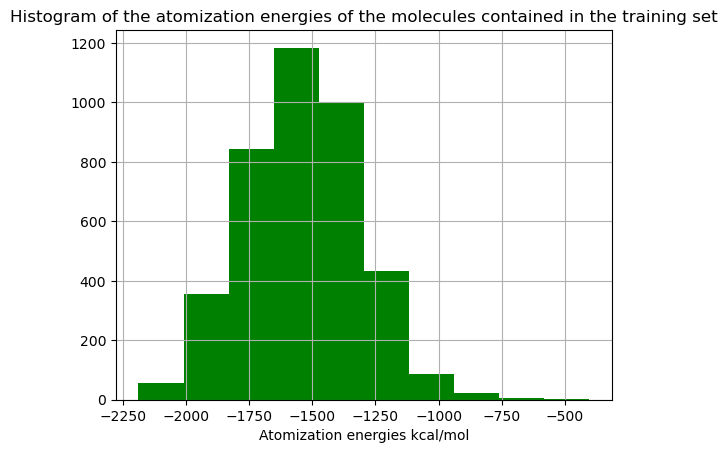

In [5]:
#Histogram of y_train

plt.hist(dataset["y_train"],facecolor = "g")

plt.xlabel('Atomization energies kcal/mol')
#plt.ylabel('')
plt.title('Histogram of the atomization energies of the molecules contained in the training set')
plt.grid(True)
plt.show()

In [6]:
# normalize the train, validation, and test labels (subtract the mean and divide by the standard deviation of the train labels)
# Keep track of the mean and the standard deviation that you used to normalize

mean_y_train = torch.mean(dataset["y_train"])
std_y_train = torch.std(dataset["y_train"])

N_y_train = (dataset["y_train"] - mean_y_train) / std_y_train
N_y_val   = (dataset["y_val"] - mean_y_train) / std_y_train  
N_y_test  = (dataset["y_test"] - mean_y_train) / std_y_train

# to check results one simple histogram of N_y_{train,val,test} can be done, as showed in the cell above
# this was omitted in order to keep the notebook clean and concise


# Exercise 3
Use torch.utils.data.TensorDataset to generate the train, validation, and test PyTorch
datasets. Then, build the train, validation, and test Pytorch dataloaders, setting the batch size to 100
and activating reshuffling at each epoch for the train data by setting shuffle=True.

In [7]:
#PyTorch datasets:
train_dataset = torch.utils.data.TensorDataset(dataset["X_train"], N_y_train)
val_dataset   = torch.utils.data.TensorDataset(dataset["X_val"], N_y_val)
test_dataset  = torch.utils.data.TensorDataset(dataset["X_test"], N_y_test)

In [8]:
#PyTorch dataloaders:

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size= 100, shuffle= True)
val_dataloader   = torch.utils.data.DataLoader(val_dataset, batch_size= 100, shuffle= True) 
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size= 100, shuffle= True) 

# Exercise 4

Define a nn.Module class for a scalar valued one-hidden-layer fully-connected network fNN (x)
with the appropriate input dimension d, p hidden neurons, and ReLU activation function.

In [9]:
#standard imports for neural networks

import torch.nn as nn
from torch import optim
import torch.nn.functional as F 

In [10]:
class NeuralNetwork(nn.Module):
    "Defines a fully connected network with the appropriate input dimension d, p hidden neurons, and ReLU activation function."
     
    def __init__(self,d,p):
        
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(d, p)
        self.fc2 = nn.Linear(p, 1)

    def forward(self, x):
        # define forward pass
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Exercise 5

Train the neural network setting p = 1000 for 1000 epochs, using the MSE loss (nn.MSELoss)
and the Adam optimizer (torch.optim.Adam). Choose from the set {10−5 , 10−4 , 10−3 , 10−2 } the
learning rate that results in the best generalization performance on the validation set. Averaging over
2-3 different random initializations of the network leads to a better picture and avoids choices based
on a poor random initialization, but it is not mandatory. All the following requests refer to the model
trained with the chosen learning rate. First, plot and analyze the behavior of the train and validation
losses during training . Finally, evaluate the performance of this model on the test set.

In [11]:
def train_loop(train_dataloader, model, epochs, learning_rate, datatype):
  """
  This function trains a neural network with SGD and its variants.
  Input: train_dataloader = iterable over the training set;
         model = neural network architecture with weights and biases;
         learning_rate = size of gradient updates;
  Output: trained neural network model and metrics stored in *.csv file. 
  """
  l = nn.MSELoss()
  o = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # extract the size of the training set
  size = len(train_dataloader.dataset)

  # initialize an empty dictionary
  res = {'epoch': [], datatype +'_loss': []}

  # loop over epochs
  for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")

    # initialize the variable for train loss  
    running_loss = 0
    
    # loop over all batches and over all input-output pair within a batch
    for batch, (X, y) in enumerate(train_dataloader):

        y = torch.reshape(y,(y.shape[0],1)) 
      
        o.zero_grad() # setting gradient to zeros
        pred = model(X) # get predictions through forward pass
        loss = l(pred, y) # compute the loss

        loss.backward() # backward propagation        
        
        o.step() # update the gradient to new gradients

    # compute the metrics of interest
        running_loss += loss.item()
          
        # check how the training is evolving accross the batches
        if batch % 10 == 0:
            current = (batch + 1) * len(X)
            print(f"Processing batch n. {batch+1} ----> running loss: {running_loss/(batch + 1):>7f}[{current:>5d}/{size:>5d}]")
    
    running_loss = running_loss/(batch + 1)
    print("")
    print(f"running {datatype} loss =  ", running_loss)
    print("")

    res['epoch'].append(e) # populate the dictionary of results
    res[datatype +'_loss'].append(running_loss)

  print("Done!")

  res = pd.DataFrame.from_dict(res) # translate the dictionary into a pandas dataframe
  res.to_csv("./metrics_over_epochs.csv", mode = 'w', index = False) # store the results into a *.csv file
  
  return

In [12]:
# plot the train loss as a function of the number of epochs
def plot_loss(learning_rate,data_type):
    fig, ax = plt.subplots(figsize=(10,7)) # initialize an empty figure and axes object
    res = pd.read_csv("./metrics_over_epochs.csv") # read the content of the *.csv file

    res.plot(x = 'epoch',
             y = data_type+ '_loss',
             color = 'blue',
             lw = 3, # linewidth
             ax=ax) # plot the results with matplotlib through pandas

    ax.set_title(f"{data_type} loss function versus number of epochs for learning rate: {learning_rate}") # set the plot title
    ax.set_ylabel(f"{data_type} loss") # set the name of the y axis
    ax.set_xlabel("epoch") # set the name of the x axis

Epoch 1
-------------------------------
Processing batch n. 1 ----> running loss: 1.037600[  100/ 4000]
Processing batch n. 11 ----> running loss: 1.045165[ 1100/ 4000]
Processing batch n. 21 ----> running loss: 1.058913[ 2100/ 4000]
Processing batch n. 31 ----> running loss: 1.022914[ 3100/ 4000]

running train loss =   1.0202871471643449

Epoch 2
-------------------------------
Processing batch n. 1 ----> running loss: 1.096200[  100/ 4000]
Processing batch n. 11 ----> running loss: 0.991659[ 1100/ 4000]
Processing batch n. 21 ----> running loss: 0.958999[ 2100/ 4000]
Processing batch n. 31 ----> running loss: 0.937147[ 3100/ 4000]

running train loss =   0.9210105299949646

Epoch 3
-------------------------------
Processing batch n. 1 ----> running loss: 0.795580[  100/ 4000]
Processing batch n. 11 ----> running loss: 0.842788[ 1100/ 4000]
Processing batch n. 21 ----> running loss: 0.853489[ 2100/ 4000]
Processing batch n. 31 ----> running loss: 0.845388[ 3100/ 4000]

running train 

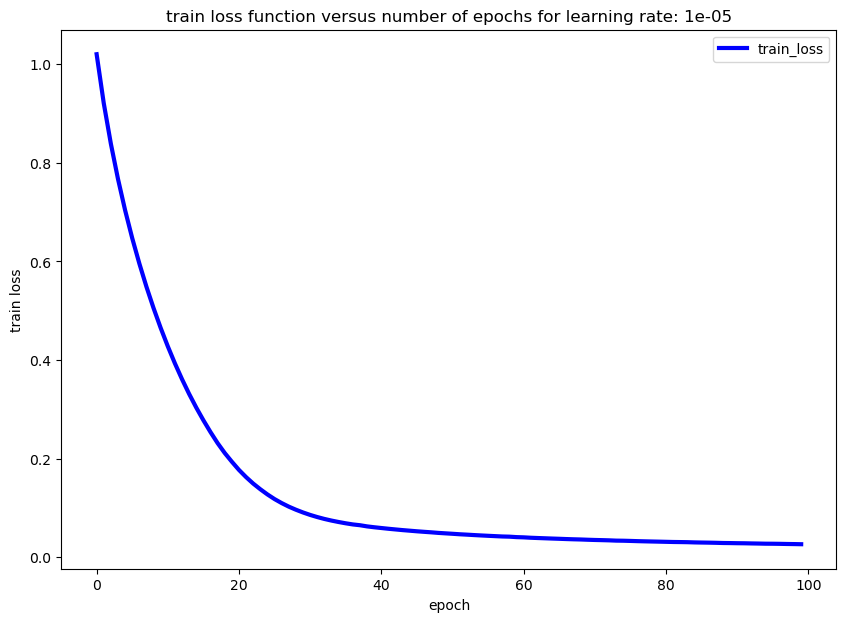

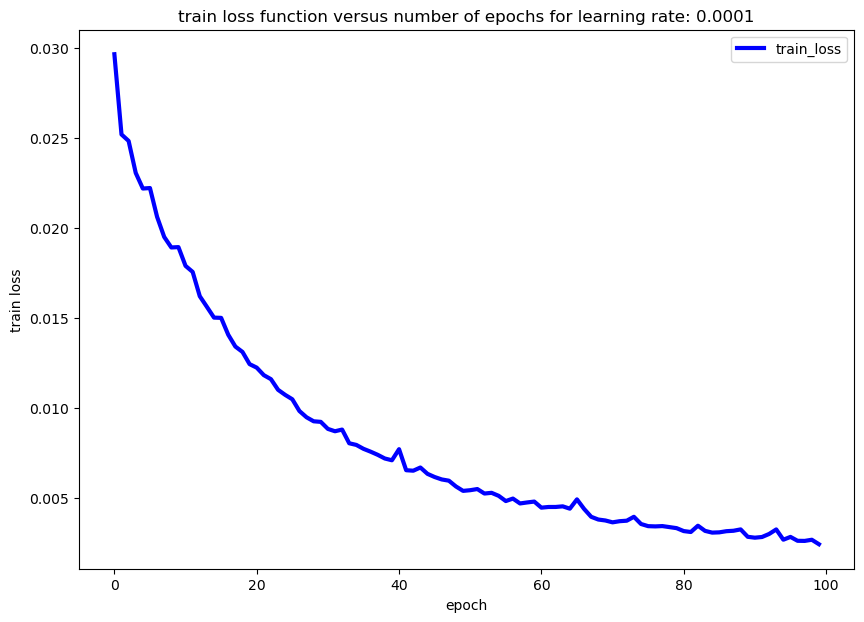

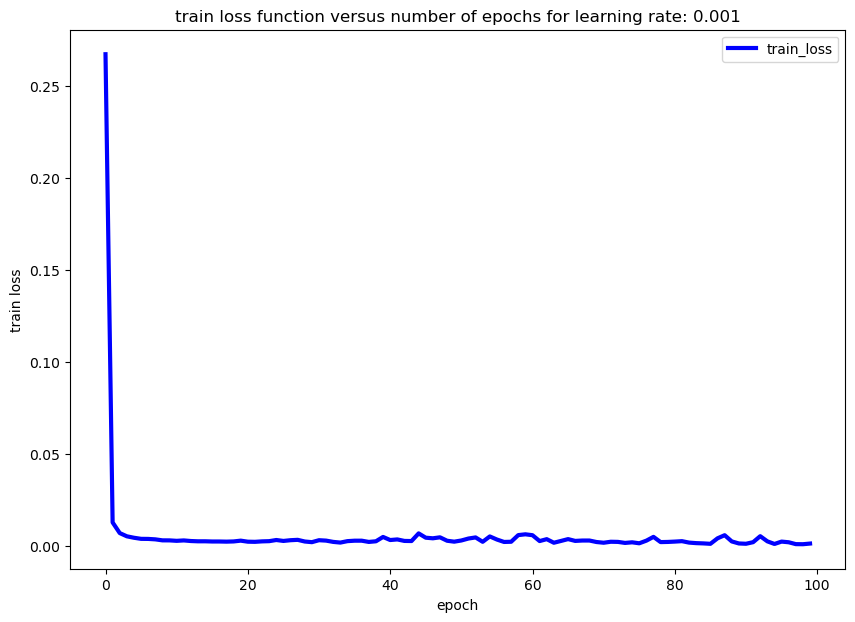

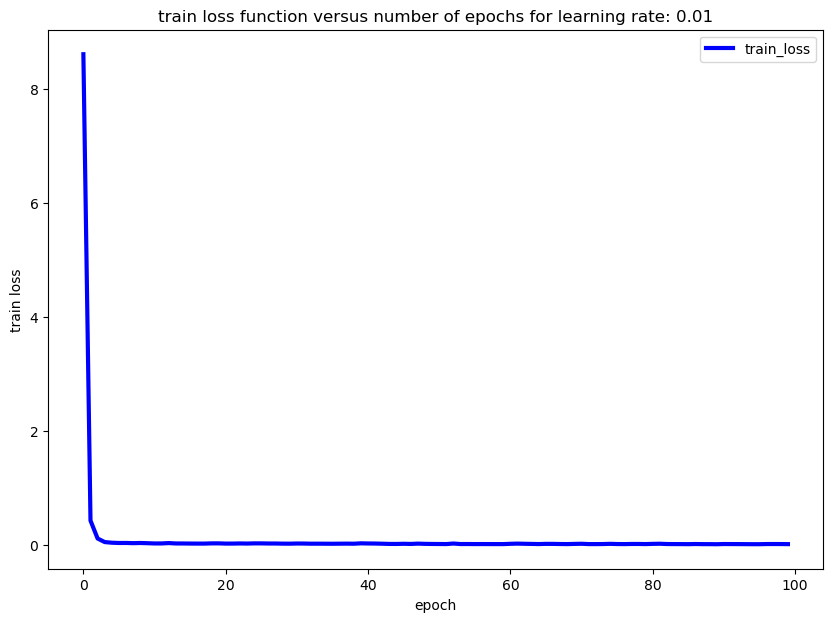

In [13]:
#Extra to determine the learning rate:

# define the neural network model
d = dataset["X_train"].shape[1]
p = 1000 

model = NeuralNetwork(d,p)


# define the hyper-parameters of the network training
#epochs = 1000
epochs = 100

learnings_rate = [1e-5,1e-4,1e-3,1e-2]

# train the network for each learning rate
for learning_rate in learnings_rate:
    train_loop(train_dataloader, model, epochs = epochs, learning_rate = learning_rate, datatype= "train")
    plot_loss(learning_rate,"train")

Epoch 1
-------------------------------
Processing batch n. 1 ----> running loss: 0.785703[  100/ 4000]
Processing batch n. 11 ----> running loss: 0.950040[ 1100/ 4000]
Processing batch n. 21 ----> running loss: 0.843162[ 2100/ 4000]
Processing batch n. 31 ----> running loss: 0.781814[ 3100/ 4000]

running train loss =   0.7164029784500598

Epoch 2
-------------------------------
Processing batch n. 1 ----> running loss: 0.424779[  100/ 4000]
Processing batch n. 11 ----> running loss: 0.445286[ 1100/ 4000]
Processing batch n. 21 ----> running loss: 0.397505[ 2100/ 4000]
Processing batch n. 31 ----> running loss: 0.363727[ 3100/ 4000]

running train loss =   0.3381321784108877

Epoch 3
-------------------------------
Processing batch n. 1 ----> running loss: 0.312588[  100/ 4000]
Processing batch n. 11 ----> running loss: 0.202205[ 1100/ 4000]
Processing batch n. 21 ----> running loss: 0.180975[ 2100/ 4000]
Processing batch n. 31 ----> running loss: 0.165889[ 3100/ 4000]

running train 

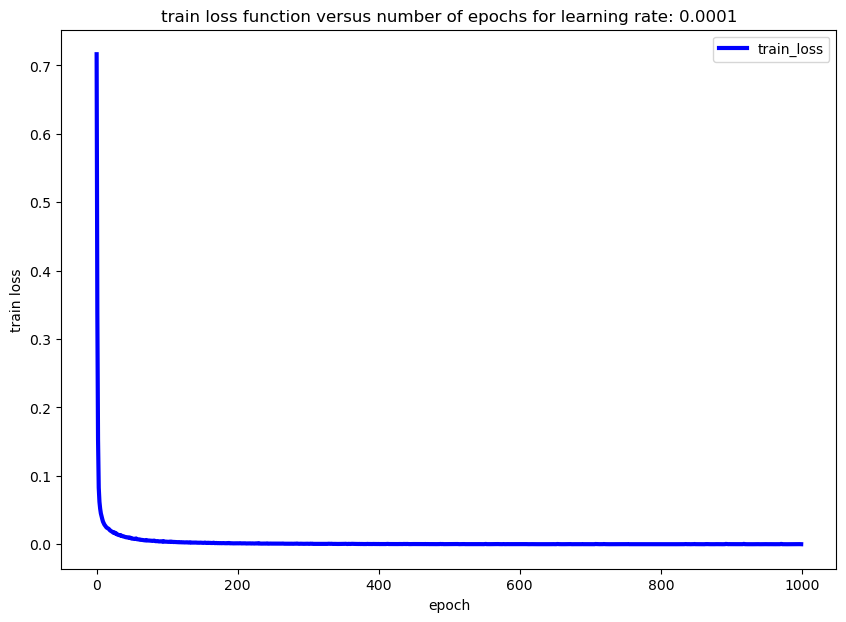

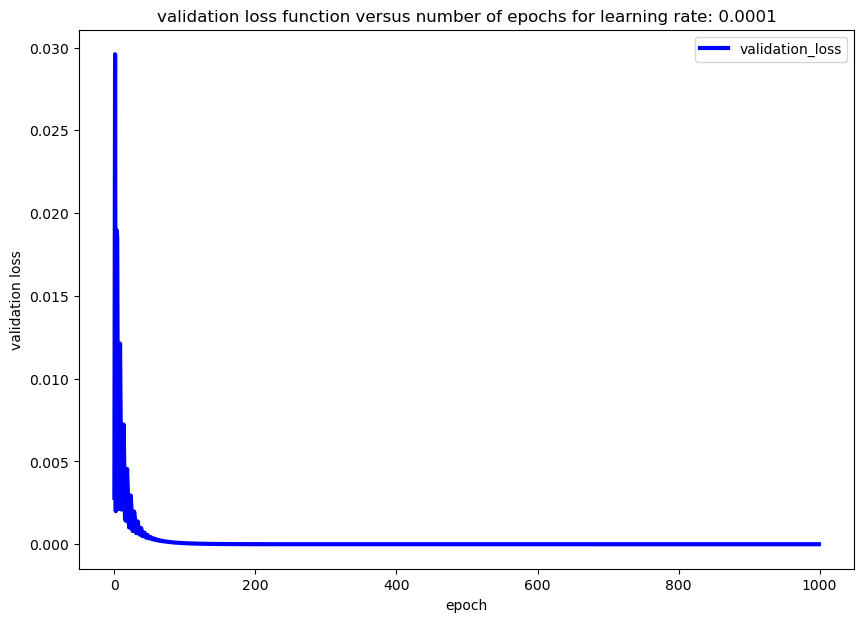

In [14]:
#Define just one learning rate

# define the neural network model
d = dataset["X_train"].shape[1]
p = 1000 

model = NeuralNetwork(d,p)


# define the hyper-parameters of the network training
epochs = 1000

learning_rate = 1e-4

# train the network

train_loop(train_dataloader, model, epochs = epochs, learning_rate = learning_rate,datatype = "train")
plot_loss(learning_rate,"train")

#validation set
train_loop(val_dataloader, model, epochs = epochs, learning_rate = learning_rate, datatype = "validation")
plot_loss(learning_rate,"validation")

In [15]:
def test_loop(test_dataloader, model):

  # initialize the variable for test loss 
  test_loss = 0.

  # select which loss function to use
  l = torch.nn.MSELoss()

  # extract the size of the test set
  size = len(test_dataloader.dataset)

  # create the container to avoid gradient computation
  with torch.no_grad():
    # loop over all test input-output pairs
    for X, y in test_dataloader: 
        
        y = torch.reshape(y,(y.shape[0],1))
        
        pred = model(X) # get predictions through forward pass
        loss = l(pred, y) # compute the loss

        
    # compute the metrics of interest    
        test_loss += loss.item()

  test_loss = test_loss/len(test_dataloader)
  
  print("test loss = ", test_loss)
  return X, y, pred

In [16]:
#Finally, evaluate the performance of this model on the test set: compute the mean square error on the test set.

X, y, pred = test_loop(test_dataloader, model)

test loss =  0.004515015741344541


# Exercise 6

Plot the energies predicted by this model on the test set vs the true energies in kcal/mol units
and compute the unnormalized root mean square error on the test set.

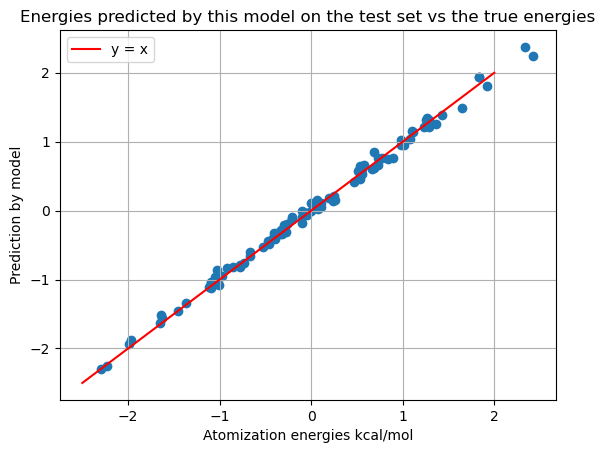

In [17]:
#Plot the energies predicted by this model on the test set vs the true energies in kcal/mol units
x1 = np.linspace(-2.5,2,1000)
y1 = x1

plt.scatter(y,pred)
plt.plot(x1,y1,label = "y = x", color = "red")
plt.legend()
plt.xlabel('Atomization energies kcal/mol')
plt.ylabel('Prediction by model')
plt.title('Energies predicted by this model on the test set vs the true energies')
plt.grid(True)

In [18]:
#compute the unnormalized root mean square error on the test set.
from sklearn.metrics import mean_squared_error

#Use the unnormalized predictions and labels. 
y = (y * std_y_train) +  mean_y_train
pred = (pred * std_y_train) +  mean_y_train

RMSE = np.sqrt(mean_squared_error(y, pred))

print(f"The unnormalized RMSE is {RMSE}")

The unnormalized RMSE is 15.462437629699707


# Exercise 7

Retrain the neural network, varying the number of training examples n ∈ {100, 200, 500, 1000}
and using the same architecture, number of epochs, loss, optimizer, and the learning rate you selected
in question 5. Plot the learning curve , i.e., unnormalized mean squared error on the test set $ε_T$ as a
function of the size of the training set n on a log-log scale. What type of curve do you observe? Identify
what function fits well $ε_T$ (n), e.g., A exp (−βn), $A (log_{10} n)^{−β}$ ,$ A n^{−β}$ , −β n + A. Find the values of
the parameters A, β by manual inspection or using another curve fitting method. Estimate the test
error that this model would achieve with n = 4000 training points, i.e., compute $ε_T$(n = 4000).

Epoch 1
-------------------------------
Processing batch n. 1 ----> running loss: 2436372.750000[  100/  100]

running train loss =   2436372.75

Epoch 2
-------------------------------
Processing batch n. 1 ----> running loss: 2436018.000000[  100/  100]

running train loss =   2436018.0

Epoch 3
-------------------------------
Processing batch n. 1 ----> running loss: 2435663.750000[  100/  100]

running train loss =   2435663.75

Epoch 4
-------------------------------
Processing batch n. 1 ----> running loss: 2435308.750000[  100/  100]

running train loss =   2435308.75

Epoch 5
-------------------------------
Processing batch n. 1 ----> running loss: 2434952.750000[  100/  100]

running train loss =   2434952.75

Epoch 6
-------------------------------
Processing batch n. 1 ----> running loss: 2434596.250000[  100/  100]

running train loss =   2434596.25

Epoch 7
-------------------------------
Processing batch n. 1 ----> running loss: 2434239.250000[  100/  100]

running train 

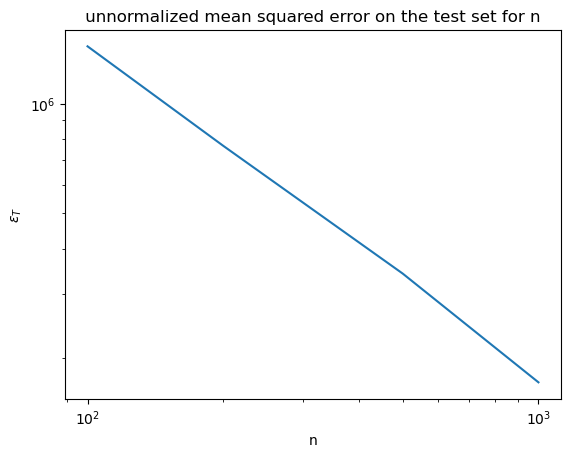

In [19]:
n_values = [100,200,500,1000]

mse = []

for n in n_values:

    #clear and initiate new datasets, with specific number of training examples:
    train_dataset_new = 0
    train_dataloader_new = 0  
    #train_dataset_new = torch.utils.data.TensorDataset(dataset["X_train"][:n], N_y_train[:n])  
    train_dataset_new = torch.utils.data.TensorDataset(dataset["X_train"][:n], dataset["y_train"][:n])  
    train_dataloader_new = torch.utils.data.DataLoader(train_dataset_new, batch_size= 100, shuffle= True)
    res = 0
    

    #Define just one learning rate

    # define the neural network model
    d = dataset["X_train"].shape[1]
    p = 1000 
    
    model = NeuralNetwork(d,p)
    
    
    # define the hyper-parameters of the network training
    epochs = 1000
    
    learning_rate = 10e-5
    
    # train the network
    
    train_loop(train_dataloader_new, model, epochs = epochs, learning_rate = learning_rate,datatype = "train")

    #compute mean squared error of the test set

    res = pd.read_csv("./metrics_over_epochs.csv")

    mse_aux = np.mean(res["train_loss"])

    mse.append(mse_aux)
        
#plot


plt.loglog(n_values,mse)
plt.xlabel('n')
plt.ylabel('$\epsilon_T$')
plt.title(' unnormalized mean squared error on the test set for n ');

 ε_T = 92785015.35705 *n^-0.90487


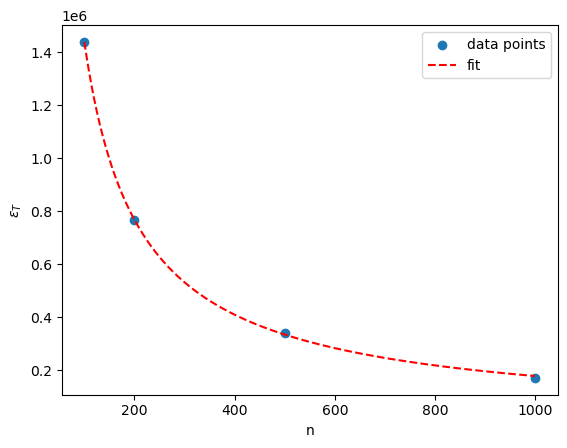

In [20]:
#Curve Fitting

from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
 
# define the true objective function
def objective(x, a, b):
 return a*(x** (-b))
 
# curve fit
popt, _ = curve_fit(objective, n_values, mse)
# summarize the parameter values
a, b = popt
print(' ε_T = %.5f *n^%.5f' % (a, -b))
# plot input vs output
pyplot.scatter(n_values, mse,label = "data points")
# define a sequence of inputs between the smallest and largest known inputs
x_line = np.arange(min(n_values), max(n_values), 1)
# calculate the output for the range
y_line = objective(x_line, a, b)
# create a line plot for the mapping function
pyplot.plot(x_line, y_line, '--', color='red',label = "fit")
plt.xlabel('n')
plt.ylabel('$\epsilon_T$')
pyplot.legend()
pyplot.show()

In [21]:
#compute εT (n = 4000)

epsilon_T = a*(4000**b)

print(f" The test error that this model would achieve with n = 4000 training points is {epsilon_T}")

 The test error that this model would achieve with n = 4000 training points is 168605941279.45822
